In [1]:
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, List, Dict, Any
import sys
import os

from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from config import MAX_RESEARCH_ATTEMPTS

from agents.research import ResearchAgent
from agents.filtering import FilteringSystem
from agents.extraction import ExtractionAgent
from agents.scoring import ScoringMechanism
from agents.recommendation import RecommendationAgent

In [2]:
class StockAnalysisState(TypedDict):
    ticker: str
    company_name: str
    research_results: Dict[str, Any]
    filtered_results: Dict[str, Any]
    extraction_results: Dict[str, Any]
    scoring_results: Dict[str, Any]
    recommendation_results: Dict[str, Any]
    error: str
    research_attempts: int

# Initialize agents
research_agent = ResearchAgent()
filtering_system = FilteringSystem()
extraction_agent = ExtractionAgent()
scoring_mechanism = ScoringMechanism()
recommendation_agent = RecommendationAgent()

In [3]:
def research_node(state: StockAnalysisState) -> StockAnalysisState:
    """Research node that fetches information about the stock."""
    print("Entering Research node.....")
    try:
        ticker = state["ticker"]
        company_name = state["company_name"]
        
        research_attempts = state.get("research_attempts", 0) + 1

        research_results = research_agent.research(ticker, company_name)
        
        return {"research_results": research_results,
                "research_attempts": research_attempts
            }
    except Exception as e:
        return {"error": f"Error in research node: {str(e)}"}

def filter_node(state: StockAnalysisState) -> StockAnalysisState:
    """Filtering node that identifies relevant articles."""
    print("Entering Filter node.....")
    try:
        research_results = state["research_results"]
        ticker = state["ticker"]
        company_name = state["company_name"]
        
        filtered_results = filtering_system.filter(research_results, ticker, company_name)
        
        return {"filtered_results": filtered_results}
    except Exception as e:
        return {"error": f"Error in filter node: {str(e)}"}

def extract_node(state: StockAnalysisState) -> StockAnalysisState:
    """Extraction node that pulls insights from filtered articles."""
    print("Entering Extract node.....")
    try:
        filtered_results = state["filtered_results"]
        
        extraction_results = extraction_agent.process(filtered_results)
        
        return {"extraction_results": extraction_results}
    except Exception as e:
        return {"error": f"Error in extract node: {str(e)}"}

def score_node(state: StockAnalysisState) -> StockAnalysisState:
    """Scoring node that evaluates the stock based on extracted insights."""
    print("Entering Score node.....")
    try:
        extraction_results = state["extraction_results"]
        
        scoring_results = scoring_mechanism.score(extraction_results)
        
        return {"scoring_results": scoring_results}
    except Exception as e:
        return {"error": f"Error in score node: {str(e)}"}

def recommend_node(state: StockAnalysisState) -> StockAnalysisState:
    """Recommendation node that generates the final investment recommendation."""
    print("Entering Recommend node.....")
    try:
        scoring_results = state["scoring_results"]
        
        recommendation_results = recommendation_agent.recommend(scoring_results)
        
        return {"recommendation_results": recommendation_results}
    except Exception as e:
        return {"error": f"Error in recommend node: {str(e)}"}

# Define routing logic
def route_after_research(state: StockAnalysisState) -> str:
    """Decide what to do after research."""
    if "error" in state and state["error"]:
        return "end"
    return "filter"

def route_after_filter(state: StockAnalysisState) -> str:
    """Decide whether to retry research or proceed to extraction."""
    print("Evaluating filter results.....")
    
    if "error" in state and state["error"]:
        return "end"
    
    filtered_results = state.get("filtered_results", {})
    filtered_articles = filtered_results.get("filtered_articles", [])
    research_attempts = state.get("research_attempts", 0)
    
    if len(filtered_articles) < 2 and research_attempts < MAX_RESEARCH_ATTEMPTS:
        # Not enough articles found, retry research
        print(f"Not enough articles ({len(filtered_articles)}), retrying research (attempt {research_attempts})...")
        return "research"
    else:
        # Proceed to extraction
        print(f"Found {len(filtered_articles)} articles, proceeding to extraction...")
        return "extract"

def route_after_extract(state: StockAnalysisState) -> str:
    """Decide what to do after extraction."""
    if "error" in state and state["error"]:
        return "end"
    return "score"

def route_after_score(state: StockAnalysisState) -> str:
    """Decide what to do after scoring."""
    if "error" in state and state["error"]:
        return "end"
    return "recommend"

def route_after_recommend(state: StockAnalysisState) -> str:
    """Decide what to do after recommendation."""
    if "error" in state and state["error"]:
        return "end"
    return "end"  # Always end after recommendation

In [6]:
graph = StateGraph(StockAnalysisState)

graph.add_node("research", research_node)
graph.add_node("filter", filter_node)
graph.add_node("extract", extract_node)
graph.add_node("score", score_node)
graph.add_node("recommend", recommend_node)

# Add conditional edges with error handling integrated
graph.add_edge(START, "research")

graph.add_conditional_edges(
    "research",
    route_after_research,
    {
        "filter": "filter",
        "end": END
    }
)

graph.add_conditional_edges(
    "filter",
    route_after_filter,
    {
        "research": "research",
        "extract": "extract",
        "end": END
    }
)

graph.add_conditional_edges(
    "extract",
    route_after_extract,
    {
        "score": "score",
        "end": END
    }
)

graph.add_conditional_edges(
    "score",
    route_after_score,
    {
        "recommend": "recommend",
        "end": END
    }
)

graph.add_conditional_edges(
    "recommend",
    route_after_recommend,
    {
        "end": END
    }
)


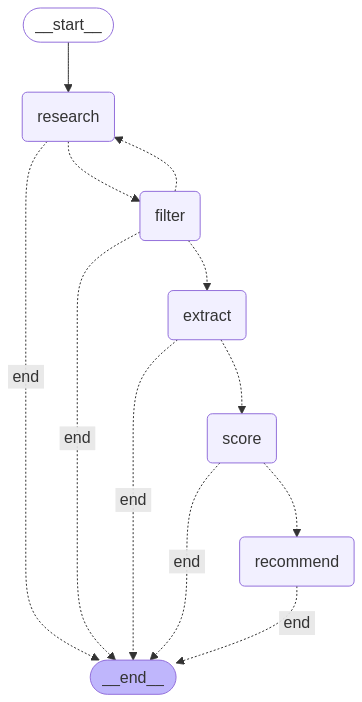

In [7]:
graph.compile()


In [8]:
ticker = 'AAPL'
company_name = 'Apple'

graph = graph.compile()
    
    # Initialize the state
initial_state = StockAnalysisState(
    ticker=ticker,
    company_name=company_name,
    research_results={},
    filtered_results={},
    extraction_results={},
    scoring_results={},
    recommendation_results={},
    error="",
    research_attempts=0  # Start with 0 attempts
)

# Execute the graph
result = graph.invoke(initial_state)

Entering Research node.....


> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'AAPL Apple recent quarterly financial results earnings analyst ratings business developments market trends competitive landscape'}`


[{'title': 'Apple Inc. (AAPL) Analyst Ratings, Estimates & Forecasts', 'url': 'https://finance.yahoo.com/quote/AAPL/analysis/', 'content': '| Currency in USD | Current Qtr. (Mar 2025) | Next Qtr. (Jun 2025) | Current Year (2025) | Next Year (2026) |\n| --- | --- | --- | --- | --- |\n| No. of Analysts | 26 | 25 | 39 | 40 |\n| Avg. Estimate | 94.06B | 89.28B | 409.05B | 441.64B |\n| Low Estimate | 89.37B | 80.69B | 389.8B | 401.4B |\n| High Estimate | 95.9B | 92.61B | 431.78B | 477.46B |\n| Year Ago Sales | 90.75B | 85.78B | 391.04B | 409.05B |\n| Sales Growth (year/est) | 3.64% | 4.08% | 4.61% | 7.97% |\nEarnings History [...] | Currency in USD | 3/31/2024 | 6/30/2024 | 9/30/2024 | 12/31/2024 |\n| --- | --- | --- | --- | --- |\n| EP

In [9]:
if "error" in result and result["error"]:
    print(f"Error: {result['error']}")
else:
    recommendation = result["recommendation_results"]
    print(f"Analysis complete for {recommendation['ticker']}!")
    print(f"Recommendation: {recommendation['score'].investment_recommendation}")
    print(f"Confidence: {recommendation['score'].confidence_level}")
    print(f"Overall Score: {recommendation['score'].overall_score}/100")
    print("\nDetailed Recommendation:")
    print(recommendation['recommendation'])

Analysis complete for AAPL!
Recommendation: Hold
Confidence: Medium
Overall Score: 58/100

Detailed Recommendation:
### Investment Recommendation for AAPL (Apple Inc.)

#### Investment Thesis
Apple Inc. (AAPL) presents a mixed investment opportunity for short-term investors over the next three months. With a solid financial foundation and a history of consistent revenue growth, Apple remains a formidable player in the technology sector. However, the lack of recent product launches and specific financial results creates uncertainty regarding immediate growth potential. The overall score of 58/100 reflects a cautious approach, suggesting that while Apple is not in a position of decline, it may not experience significant upward momentum in the short term.

Investors should closely monitor upcoming earnings reports and any announcements regarding new products or services, as these could serve as catalysts for stock price movement. Given the neutral analyst sentiment and moderate momentum, 